<a href="https://colab.research.google.com/github/summiyak/NLP_Final_project/blob/main/Cartography_outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/')

Mounted at /content/drive


In [2]:
!pip install -r /content/drive/MyDrive/electra/fp-dataset-artifacts-main/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [22]:
import numpy as np
import pandas as pd
from datasets import Dataset
import json


def load_jsonl_predictions(file_path):
      json_dataset = []  # Initialize an empty list to store JSON objects
      with open(file_path, 'r') as f:
          for line in f:  # Read the file line by line
              try:
                  data = json.loads(line)  # Parse each line as a JSON object
                  json_dataset.append(data)  # Add the parsed object to the list
              except json.JSONDecodeError as e:
                  print(f"Error decoding JSON: {e}, skipping line: {line}")

      dataset = Dataset.from_list(json_dataset)
      # Example Data (Replace with actual data)
      data = json_dataset

      num_classes = 3  # Number of label classes



      def token_overlap_ratio(premise, hypothesis):
          premise_tokens = set(premise.split())
          hypothesis_tokens = set(hypothesis.split())
          intersection = len(premise_tokens & hypothesis_tokens)
          return intersection / len(premise_tokens)

      # Define Error Classes
      error_classes = {
          "Negation": lambda x: any(word in x["premise"].split(" ") + x["hypothesis"].split(" ") for word in ["not", "no", "never", "without"]),
          "Coreference": lambda x: any(word in x["hypothesis"] for word in ["he", "she", "it", "they"]),
          "Rare Words": lambda x: any(word in x["premise"] for word in ["Higgs", "boson", "quantum"]),
          "Ambiguity": lambda x: any(word in x["hypothesis"] for word in ["something", "someone", "several"]),
          "Long Sentences": lambda x: len(x["premise"].split()) > 10 or len(x["hypothesis"].split()) > 10,
          "High Lexical Overlap": lambda x: token_overlap_ratio(x["premise"], x["hypothesis"]) > 0.7,
      }



      # Initialize Counters
      error_counts = {cls: 0 for cls in error_classes}
      total_counts = {cls: 0 for cls in error_classes}
      error_examples = {cls: [] for cls in error_classes}

      # Process Examples
      for example in data:
          true_label = example['label']
          predicted_label = example['predicted_label']
          is_error = true_label != predicted_label  # Check if the prediction is incorrect

          for cls, rule in error_classes.items():
              if rule(example):  # Check if example matches the error class
                  total_counts[cls] += 1
                  if is_error:
                      error_counts[cls] += 1
                      error_examples[cls].append(example)

      # Calculate Metrics
      error_rates = {cls: (error_counts[cls] / total_counts[cls] * 100 if total_counts[cls] > 0 else 0) for cls in error_classes}
      frequencies = {cls: (total_counts[cls] / len(data) * 100) for cls in error_classes}

      # Create Summary Table
      summary_table = pd.DataFrame({
          "Error Class": list(error_classes.keys()),
          "Frequency (%)": [frequencies[cls] for cls in error_classes],
          "Error Rate (%)": [error_rates[cls] for cls in error_classes],
          "Error Count": [error_counts[cls] for cls in error_classes],
      })

      # Display Results
      print(summary_table)


#Results on SNLI Datasets

**Results of Pretrained Model**

In [31]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/pretrained_eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count
0              Negation       1.574883       11.612903           18
1           Coreference      64.661654       11.329353          721
2            Rare Words       0.000000        0.000000            0
3             Ambiguity       1.158301       20.175439           23
4        Long Sentences      68.258484       10.657934          716
5  High Lexical Overlap       3.881325        9.162304           35


**Results of Finetuned model on Ambiguous dataset**

In [ ]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset snli --model /content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_easy/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/

{'eval_loss': 0.31365907192230225, 'eval_model_preparation_time': 0.0033, 'eval_accuracy': **0.8941271901130676**, 'eval_runtime': 26.0593, 'eval_samples_per_second': 377.676, 'eval_steps_per_second': 47.238}

In [28]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/finetuned_eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count
0              Negation       1.574883       10.322581           16
1           Coreference      64.661654       11.486486          731
2            Rare Words       0.000000        0.000000            0
3             Ambiguity       1.158301       19.298246           22
4        Long Sentences      68.258484       10.881215          731
5  High Lexical Overlap       3.881325        8.115183           31


**Results of Fineuned model on Easy Dataset**

In [ ]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset snli --model /content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_cartography/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/

{'eval_loss': 0.32033270597457886, 'eval_model_preparation_time': 0.006, 'eval_accuracy': **0.8913838863372803**, 'eval_runtime': 24.9461, 'eval_samples_per_second': 394.53, 'eval_steps_per_second': 49.346}

In [29]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/easy_eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count
0              Negation       1.574883       12.258065           19
1           Coreference      64.661654       11.407920          726
2            Rare Words       0.000000        0.000000            0
3             Ambiguity       1.158301       16.666667           19
4        Long Sentences      68.258484       10.628163          714
5  High Lexical Overlap       3.881325        9.162304           35


**Results of Fineuned model on Hard Dataset**

In [ ]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset snli --model /content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_hard/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/

Evaluation results:
{'eval_loss': 0.33475616574287415, 'eval_model_preparation_time': 0.0063, 'eval_accuracy':**0.8927047252655029**, 'eval_runtime': 25.5807, 'eval_samples_per_second': 384.743, 'eval_steps_per_second': 48.122}

In [30]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/hard_eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count
0              Negation       1.574883       12.903226           20
1           Coreference      64.661654       11.407920          726
2            Rare Words       0.000000        0.000000            0
3             Ambiguity       1.158301       21.052632           24
4        Long Sentences      68.258484       10.613278          713
5  High Lexical Overlap       3.881325        7.068063           27


# Results on MNLI Datasets

**OOD Dataset**

**Just Pretrained Model**

In [14]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset /content/drive/MyDrive/electra/datasets/mnli.json --model /content/drive/MyDrive/electra/trained_model/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_mismatched/

2024-11-28 20:54:49.182833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 20:54:49.202191: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 20:54:49.208179: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 20:54:49.222351: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 20:54:50.532227: W tensorflow/comp

{'eval_loss': 0.9774576425552368, 'eval_model_preparation_time': 0.0032, 'eval_accuracy': **0.7010781168937683**, 'eval_runtime': 19.2295, 'eval_samples_per_second': 511.297, 'eval_steps_per_second': 63.912}

In [32]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_mismatched/eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count
0              Negation      21.887714       29.182156          628
1           Coreference      77.583401       30.361825         2316
2            Rare Words       0.000000        0.000000            0
3             Ambiguity       1.362897       38.805970           52
4        Long Sentences      79.068348       30.499100         2371
5  High Lexical Overlap       3.224166       15.772871           50


**Pre-trained Finetuned (Entire Dataset) Model**

In [4]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset /content/drive/MyDrive/electra/datasets/mnli.json --model /content/drive/MyDrive/electra/cartography/cart_final/model/Pretrained_cartography/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_mismatched/

2024-11-28 20:40:37.473897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 20:40:37.493576: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 20:40:37.501665: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 20:40:37.515910: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 20:40:39.007232: W tensorflow/comp

Evaluation results:
{'eval_loss': 0.8103671073913574, 'eval_model_preparation_time': 0.0037, 'eval_accuracy': **0.6982302665710449**, 'eval_runtime': 18.6238, 'eval_samples_per_second': 527.928, 'eval_steps_per_second': 65.991}

In [33]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_mismatched/pretrained_eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count
0              Negation      21.887714       29.182156          628
1           Coreference      77.583401       30.702674         2342
2            Rare Words       0.000000        0.000000            0
3             Ambiguity       1.362897       34.328358           46
4        Long Sentences      79.068348       30.897865         2402
5  High Lexical Overlap       3.224166       15.772871           50


**Model Fine-tuned on Easy Examaples**

In [7]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset /content/drive/MyDrive/electra/datasets/mnli.json --model /content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_easy/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_mismatched/

2024-11-28 20:47:21.420884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 20:47:21.454987: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 20:47:21.465499: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 20:47:21.488820: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 20:47:22.926042: W tensorflow/comp

Evaluation results:
{'eval_loss': 0.7863791584968567, 'eval_model_preparation_time': 0.0054, 'eval_accuracy': **0.7037225365638733**, 'eval_runtime': 18.7515, 'eval_samples_per_second': 524.332, 'eval_steps_per_second': 65.542}

In [34]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_mismatched/easy_eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count
0              Negation      21.887714       28.856877          621
1           Coreference      77.583401       30.256948         2308
2            Rare Words       0.000000        0.000000            0
3             Ambiguity       1.362897       36.567164           49
4        Long Sentences      79.068348       30.203242         2348
5  High Lexical Overlap       3.224166       17.981073           57


**Model Fine-tuned on Ambigous Examples**

In [9]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset /content/drive/MyDrive/electra/datasets/mnli.json --model /content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_cartography/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_mismatched/

2024-11-28 20:49:11.212477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 20:49:11.231794: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 20:49:11.237586: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 20:49:11.252933: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 20:49:12.272390: W tensorflow/comp

{'eval_loss': 0.8081018924713135, 'eval_model_preparation_time': 0.0031, 'eval_accuracy': **0.6979251503944397**, 'eval_runtime': 17.6294, 'eval_samples_per_second': 557.705, 'eval_steps_per_second': 69.713}

In [35]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_mismatched/amb_eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count
0              Negation      21.887714       30.622677          659
1           Coreference      77.583401       30.833770         2352
2            Rare Words       0.000000        0.000000            0
3             Ambiguity       1.362897       38.059701           51
4        Long Sentences      79.068348       30.769231         2392
5  High Lexical Overlap       3.224166       16.719243           53


**Model Fine-tuned on Hard Examples**

In [11]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset /content/drive/MyDrive/electra/datasets/mnli.json --model /content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_hard/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_mismatched/

2024-11-28 20:51:53.362036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 20:51:53.381315: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 20:51:53.387074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 20:51:53.401046: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 20:51:54.404162: W tensorflow/comp

{'eval_loss': 0.8554939031600952, 'eval_model_preparation_time': 0.0032, 'eval_accuracy': **0.6946704387664795**, 'eval_runtime': 17.8336, 'eval_samples_per_second': 551.318, 'eval_steps_per_second': 68.915}


In [36]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_mismatched/hard_eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count
0              Negation      21.887714       30.901487          665
1           Coreference      77.583401       30.925537         2359
2            Rare Words       0.000000        0.000000            0
3             Ambiguity       1.362897       35.074627           47
4        Long Sentences      79.068348       31.090816         2417
5  High Lexical Overlap       3.224166       15.457413           49


# MNLI Matched

**Trained Model**

In [17]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset /content/drive/MyDrive/electra/datasets/mnli_matched.json --model /content/drive/MyDrive/electra/trained_model/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_matched/

2024-11-28 21:10:41.522447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 21:10:41.541727: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 21:10:41.547497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 21:10:41.563183: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 21:10:42.583419: W tensorflow/comp

Evaluation results:
{'eval_loss': 1.0004066228866577, 'eval_model_preparation_time': 0.0054, 'eval_accuracy': **0.690473735332489**, 'eval_runtime': 18.0353, 'eval_samples_per_second': 544.211, 'eval_steps_per_second': 68.033}

In [23]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_matched/trained_eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count
0              Negation      21.090168       32.318841          669
1           Coreference      76.016302       31.282670         2334
2            Rare Words       0.000000        0.000000            0
3             Ambiguity       1.314315       34.108527           44
4        Long Sentences      75.425369       31.703364         2347
5  High Lexical Overlap       2.363729       16.810345           39


**Pre-trained Finetuned (Entire Dataset) Model**

In [18]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset /content/drive/MyDrive/electra/datasets/mnli_matched.json --model /content/drive/MyDrive/electra/cartography/cart_final/model/Pretrained_cartography/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_matched/

2024-11-28 21:15:19.135725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 21:15:19.155076: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 21:15:19.160922: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 21:15:19.175777: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 21:15:20.176519: W tensorflow/comp

{'eval_loss': 0.8231008052825928, 'eval_model_preparation_time': 0.0032, 'eval_accuracy': **0.6897605657577515**, 'eval_runtime': 18.0117, 'eval_samples_per_second': 544.924, 'eval_steps_per_second': 68.122}


In [24]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_matched/pretrained_eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count
0              Negation      21.090168       30.869565          639
1           Coreference      76.016302       31.443506         2346
2            Rare Words       0.000000        0.000000            0
3             Ambiguity       1.314315       34.108527           44
4        Long Sentences      75.425369       31.730380         2349
5  High Lexical Overlap       2.363729       21.551724           50


**Finetuned on ambiguous dataset Model**

In [19]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset /content/drive/MyDrive/electra/datasets/mnli_matched.json --model /content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_cartography/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_matched/

2024-11-28 21:17:33.798043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 21:17:33.817206: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 21:17:33.823036: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 21:17:33.836838: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 21:17:34.850641: W tensorflow/comp

{'eval_loss': 0.8226026296615601, 'eval_model_preparation_time': 0.0054, 'eval_accuracy':**0.6859908103942871**, 'eval_runtime': 18.6905, 'eval_samples_per_second': 525.134, 'eval_steps_per_second': 65.648}

In [25]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_matched/amb_eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count
0              Negation      21.090168       32.657005          676
1           Coreference      76.016302       31.590940         2357
2            Rare Words       0.000000        0.000000            0
3             Ambiguity       1.314315       33.333333           43
4        Long Sentences      75.425369       31.946508         2365
5  High Lexical Overlap       2.363729       16.379310           38


**Finetuned on Easy dataset Model**

In [20]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset /content/drive/MyDrive/electra/datasets/mnli_matched.json --model /content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_easy/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_matched/

2024-11-28 21:19:38.217513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 21:19:38.237343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 21:19:38.243191: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 21:19:38.257153: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 21:19:39.306484: W tensorflow/comp

{'eval_loss': 0.7971116304397583, 'eval_model_preparation_time': 0.0032, 'eval_accuracy': **0.6935303211212158**, 'eval_runtime': 18.3543, 'eval_samples_per_second': 534.753, 'eval_steps_per_second': 66.851}

In [26]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_matched/easy_eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count
0              Negation      21.090168       31.352657          649
1           Coreference      76.016302       31.175446         2326
2            Rare Words       0.000000        0.000000            0
3             Ambiguity       1.314315       31.782946           41
4        Long Sentences      75.425369       31.554775         2336
5  High Lexical Overlap       2.363729       17.672414           41


**Finetuned on hard dataset Model**

In [21]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset /content/drive/MyDrive/electra/datasets/mnli_matched.json --model /content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_hard/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_matched/

2024-11-28 21:21:04.575649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 21:21:04.607735: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 21:21:04.617478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 21:21:04.639494: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 21:21:06.143525: W tensorflow/comp

{'eval_loss': 0.8663884401321411, 'eval_model_preparation_time': 0.0031, 'eval_accuracy': **0.6851757764816284**, 'eval_runtime': 17.8781, 'eval_samples_per_second': 548.996, 'eval_steps_per_second': 68.631}

In [27]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_matched/hard_eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count
0              Negation      21.090168       32.512077          673
1           Coreference      76.016302       31.631149         2360
2            Rare Words       0.000000        0.000000            0
3             Ambiguity       1.314315       34.108527           44
4        Long Sentences      75.425369       32.068081         2374
5  High Lexical Overlap       2.363729       17.672414           41


In [7]:
import json
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def calculate_confusion_matrix(file_path):
      json_dataset = []  # Initialize an empty list to store JSON objects
      with open(file_path, 'r') as f:
          for line in f:  # Read the file line by line
              try:
                  data = json.loads(line)  # Parse each line as a JSON object
                  json_dataset.append(data)  # Add the parsed object to the list
              except json.JSONDecodeError as e:
                  print(f"Error decoding JSON: {e}, skipping line: {line}")


      # Example Data (Replace with actual data)
      results = json_dataset



      # Step 1: Extract true and predicted labels
      true_labels = [item["label"] for item in results]
      predicted_labels = [item["predicted_label"] for item in results]

      # Step 2: Compute confusion matrix
      classes = ["Entailment", "Neutral", "Contradiction"]  # Class names for NLI tasks
      conf_matrix = confusion_matrix(true_labels, predicted_labels)

      # Step 3: Display the confusion matrix
      disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
      disp.plot(cmap=plt.cm.Blues)

      # Step 4: Show plot
      plt.title("Confusion Matrix")
      plt.show()


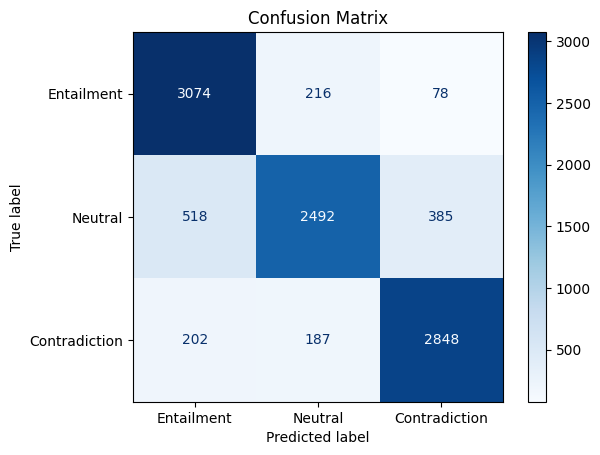

In [9]:
calculate_confusion_matrix("/content/drive/MyDrive/electra/output_remove_stop_words/eval_predictions.jsonl")

**Old Experiments**

**MNLI Matched**

In [3]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset /content/drive/MyDrive/electra/datasets/mnli_matched.json --model /content/drive/MyDrive/electra/trained_model/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/mnli/output/

2024-11-29 02:31:16.772270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 02:31:16.792567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 02:31:16.798843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 02:31:16.813670: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-29 02:31:18.236930: W tensorflow/comp

In [4]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset /content/drive/MyDrive/electra/datasets/mnli.json --model /content/drive/MyDrive/electra/trained_model/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/mnli/output/

2024-11-29 02:35:09.198885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 02:35:09.219080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 02:35:09.224970: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 02:35:09.239626: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-29 02:35:10.284400: W tensorflow/comp

In [8]:
import json

def readjsondata(file_path):
      json_dataset = []  # Initialize an empty list to store JSON objects
      with open(file_path, 'r') as f:
          for line in f:  # Read the file line by line
              try:
                  data = json.loads(line)  # Parse each line as a JSON object
                  json_dataset.append(data)  # Add the parsed object to the list
              except json.JSONDecodeError as e:
                  print(f"Error decoding JSON: {e}, skipping line: {line}")

      #dataset = Dataset.from_list(json_dataset)
      # Example Data (Replace with actual data)
      return json_dataset

**SNLI Pretrained Initial Model Results for MNLI**

In [10]:
mnli_pretrained_matched = readjsondata("/content/drive/MyDrive/electra/cartography/cart_final/mnli/output/mnlimatched_pretrained_eval_predictions.jsonl")
mnli_pretrained_mismatched = readjsondata("/content/drive/MyDrive/electra/cartography/cart_final/mnli/output/mnlimismatched_eval_predictions.jsonl")

**Cartography - SNLI Pretrained Initial Model Results for MNLI**

In [11]:
cart_mnli_pretrained_matched = readjsondata("/content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_matched/easy_eval_predictions.jsonl")
cart_mnli_pretrained_mismatched = readjsondata("/content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_mismatched/easy_eval_predictions.jsonl")

In [12]:
print(len(mnli_pretrained_matched))
print(len(mnli_pretrained_mismatched))
print(len(cart_mnli_pretrained_matched))
print(len(cart_mnli_pretrained_mismatched))

9815
9832
9815
9832


In [16]:
print(mnli_pretrained_matched[5])
print(cart_mnli_pretrained_matched[5])

{'premise': "well that would be a help i wish they would do that here we have got so little landfill space left that we're going to run out before the end of this decade and it's really going to be", 'hypothesis': 'We have plenty of space in the landfill.', 'label': 2, 'predicted_scores': [2.20771861076355, -0.3852190375328064, -3.1107168197631836], 'predicted_label': 0}
{'premise': "well that would be a help i wish they would do that here we have got so little landfill space left that we're going to run out before the end of this decade and it's really going to be", 'hypothesis': 'We have plenty of space in the landfill.', 'label': 2, 'predicted_scores': [1.510895848274231, 0.1004837155342102, -2.6060330867767334], 'predicted_label': 0}


**Errors that are corrected by Cartography**

In [19]:
def token_overlap_ratio(premise, hypothesis):
          premise_tokens = set(premise.split())
          hypothesis_tokens = set(hypothesis.split())
          intersection = len(premise_tokens & hypothesis_tokens)
          return intersection / len(premise_tokens)

error_classes = {
          "Negation": lambda x: any(word in x["premise"].split(" ") + x["hypothesis"].split(" ") for word in ["not", "no", "never", "without"]),
          "Coreference": lambda x: any(word in x["hypothesis"] for word in ["he", "she", "it", "they"]),
          "Rare Words": lambda x: any(word in x["premise"] for word in ["Higgs", "boson", "quantum"]),
          "Ambiguity": lambda x: any(word in x["hypothesis"] for word in ["something", "someone", "several"]),
          "Long Sentences": lambda x: len(x["premise"].split()) > 10 or len(x["hypothesis"].split()) > 10,
          "High Lexical Overlap": lambda x: token_overlap_ratio(x["premise"], x["hypothesis"]) > 0.7,
      }



      # Initialize Counters
error_counts = {cls: 0 for cls in error_classes}
total_counts = {cls: 0 for cls in error_classes}
error_examples = {cls: [] for cls in error_classes}




for i,example in enumerate(mnli_pretrained_matched):
    for cls, rule in error_classes.items():
          if rule(example):  # Check if example matches the error class
                total_counts[cls] += 1
                if example['predicted_label'] != example['label']:
                  if cart_mnli_pretrained_matched[i]['predicted_label'] != cart_mnli_pretrained_matched[i]['label']:
                          error_examples[cls].append(example)


In [21]:
print(len(error_examples))

6
